### SETUP INICIAL DO PROJETO

In [54]:

#importação das bibliotecase e pacotes necessários para a análise

import json
import numpy as np
import os
import pandas as pd
import pandas_gbq as gbq
import re
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from google.cloud import bigquery
from google.cloud.bigquery_storage import BigQueryReadClient
from google.oauth2 import service_account

# Carrega o .env: onde estão as credenciais do projeto/repositório
load_dotenv("/mnt/c/Users/wrpen/OneDrive/Desktop/df_lh/.env")

# Detectar ambiente: como eu estou usando wsl-ubuntu, no VS Code  -  Windows, estava dando conflitos de path
if os.name == "nt":  # se Windows
    credentials_path = r"C:\Temp\desafiolh-445818-3cb0f62cb9ef.json"
else:  # se WSL/Linux
    credentials_path = "/mnt/c/Temp/desafiolh-445818-3cb0f62cb9ef.json"

# Parâmetros injetados pelo Papermill ou definidos manualmente, caso não existam no ambiente
# Tables_to_process: lista de tabelas que serão processadas
# Output_dataset: nome do dataset onde os dados processados serão armazenados, neste caso, raw_data_cleaned
if 'tables_to_process' not in locals():
    tables_to_process = [
        "desafioadventureworks-446600.raw_data.person-person"       
    ]

if 'output_dataset' not in locals():
    output_dataset = "desafioadventureworks-446600.raw_data_cleaned"

# Configs do cliente BigQuery: input de project e location de acordo com dados no Bigquery
credentials = service_account.Credentials.from_service_account_file(credentials_path)
client = bigquery.Client(credentials=credentials, project=os.getenv("BIGQUERY_PROJECT"), location="us-central1")


In [55]:
# Print com a tabela que vai ser processada nesse notebook

print("Tabelas a processar:", tables_to_process)

Tabelas a processar: ['desafioadventureworks-446600.raw_data.person-person']


In [56]:
# Nome do dataset no Bigquery com os dados brutos (.csv) extraídos pelo Meltano 
dataset_id = 'raw_data'
print(dataset_id)

# Lista de tabelas do dataset raw_data no Bigquery
tables = client.list_tables('raw_data')
print("Tabelas disponíveis:")
for table in tables:
    print(table.table_id)

raw_data
Tabelas disponíveis:
humanresources-employee
person-address
person-businessentity
person-person
person-stateprovince
production-location
production-product
production-productcategory
production-productinventory
production-productsubcategory
sales-customer
sales-salesorderdetail
sales-salesorderheader
sales-salesterritory
sales-store


# Exploratory Data Analysis (EDA) e Data Cleaning

### Glossário dos dados:

O termo ''doc:'', situado no rodapé de algumas cells, indica algo como:

- documentação: documentar decisões, análises e resultados;

- abreviações de termos, como bkp, df, entre outros.

In [57]:
# Configuração para que o df exiba todas as colunas e todas as linhas completas, e também, exiba o formato numérico com 2 dígitos após a vírgula

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 10000)
pd.options.display.float_format = '{:.2f}'.format


#doc: df = dataframe  

In [58]:
# Dicionário para armazenar os df processados
df_processados = {}

# Iteração das tabelas e armazenamento em df
for input_table in tables_to_process:
    print(f"Processando tabela: {input_table}")
    
    # Nome da tabela com substituição de '-' por '_'
    table_name = input_table.split(".")[-1].replace("-", "_")  
    
    # Ler os dados da tabela do BigQuery para um df
    print("Lendo os dados do BigQuery...")
    query = f"SELECT * FROM `{input_table}`"
    table_data = client.query(query).to_dataframe()
    
    # Armazenar o df no dicionário
    df_processados[table_name] = table_data
    print(f"Tabela {table_name} processada e armazenada com sucesso.")

# Print de validação
print("Todas as tabelas foram processadas com sucesso!")


Processando tabela: desafioadventureworks-446600.raw_data.person-person
Lendo os dados do BigQuery...
Tabela person_person processada e armazenada com sucesso.
Todas as tabelas foram processadas com sucesso!


In [59]:
# Listar todas as variáveis criadas dinamicamente
for table_name in df_processados.keys():
    print(f"Variável criada: {table_name}")  

Variável criada: person_person


In [60]:
# Atribuir o df a uma variável com nome mais simples
person_person = df_processados['person_person']

print(f"Colunas: {person_person.shape[1]}\nLinhas: {person_person.shape[0]}")

Colunas: 13
Linhas: 299580


In [61]:
# Identificar duplicadas com base em 'businessentityid'
duplicadas = person_person[
    person_person.duplicated(subset=['businessentityid'], keep=False)
]

# Verificar se existem duplicadas
if not duplicadas.empty:
    # Ordenar duplicadas por 'businessentityid' e 'modifieddate'
    duplicadas_ordenadas = duplicadas.sort_values(by=['businessentityid', 'modifieddate'])

    # Exibir duplicadas ordenadas
    print("duplicadas ordenadas:")
    print(duplicadas_ordenadas)
else:
    print("Não foram encontradas duplicadas.")

duplicadas ordenadas:
        businessentityid persontype  namestyle title firstname middlename lastname suffix  emailpromotion additionalcontactinfo                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                demographics                               rowguid              modifieddate
7386                   1         EM      False  None       Ken          J  Sánchez   None               0                  None                                                       

In [62]:
# Remover duplicadas mantendo a última ocorrência com base em 'modifieddate', pois ela que indica a data da última modificação nos dados
# Importante, pois se houver erro na ingestão (duplicação), mantém os dados integros.

person_person = person_person.drop_duplicates(subset=['businessentityid'], keep='last')

print(f"Linhas após remover duplicadas (baseando-se na última 'modifieddate'): {len(person_person)}")

#bkp dos dados brutos
raw_data_bkp_2_sem_duplicadas = person_person.copy()


#doc: bkp = backup (cópia)

Linhas após remover duplicadas (baseando-se na última 'modifieddate'): 19972


In [63]:
# Ordenar e exibir o df por 'businessentityid'
person_person = person_person.sort_values(by=['businessentityid'])

print(person_person)

        businessentityid persontype  namestyle title firstname middlename    lastname suffix  emailpromotion additionalcontactinfo                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       demographics                               rowguid              modifieddate
286994                 1         EM      False  None       Ken          J     Sánchez   None               0                  None                                                                

In [64]:
# Iterar por todas as colunas do df, para verificar valores ausentes

# Verificar valores ausentes na coluna
for column in person_person.columns:   
    missing_rows = person_person[person_person[column].isnull()]
    print(f"Coluna '{column}': {missing_rows.shape[0]} linhas ausentes.")
    
# Mostrar as primeiras linhas ausentes, se preciso for, limitar o head() para dar menos outputs ou limitar os outputs
    if not missing_rows.empty:
        print(f"Exibindo as primeiras linhas com valores ausentes em '{column}':")
        print(missing_rows.head(), "\n")
    else:
        print(f"Nenhuma linha com valores ausentes em '{column}'.\n")

Coluna 'businessentityid': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'businessentityid'.

Coluna 'persontype': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'persontype'.

Coluna 'namestyle': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'namestyle'.

Coluna 'title': 18963 linhas ausentes.
Exibindo as primeiras linhas com valores ausentes em 'title':
        businessentityid persontype  namestyle title firstname middlename    lastname suffix  emailpromotion additionalcontactinfo                                                                                                                                                         demographics                               rowguid              modifieddate
286994                 1         EM      False  None       Ken          J     Sánchez   None               0                  None  <IndividualSurvey xmlns="http://schemas.microsoft.com/sqlserver/2004/07/adventure-works/IndividualSurvey"><TotalPurcha

In [65]:
#deletar colunas com muitos valores ausentes
person_person = person_person.drop(columns=['title', 'middlename', 'suffix', 'additionalcontactinfo', 'namestyle', 'demographics'])


#doc: As colunas title, middlename, suffix e additionalcontactinfo foram deletadas, pois há muitos valores ausentes.
#     com exceção da coluna namestyle, que há dados, mas como uma coluna booleana, ela só tem false, o que também não agrega valor a análise e
#     da coluna demographics, que também há dados, mas para o momento, não há necessidade de utlizá-la

In [66]:
# Iterar por todas as colunas do df, para verificar valores ausentes

# Verificar valores ausentes na coluna
for column in person_person.columns:   
    missing_rows = person_person[person_person[column].isnull()]
    print(f"Coluna '{column}': {missing_rows.shape[0]} linhas ausentes.")
    
# Mostrar as primeiras linhas ausentes, se preciso for, limitar o head() para dar menos outputs ou limitar os outputs
    if not missing_rows.empty:
        print(f"Exibindo as primeiras linhas com valores ausentes em '{column}':")
        print(missing_rows.head(), "\n")
    else:
        print(f"Nenhuma linha com valores ausentes em '{column}'.\n")

Coluna 'businessentityid': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'businessentityid'.

Coluna 'persontype': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'persontype'.

Coluna 'firstname': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'firstname'.

Coluna 'lastname': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'lastname'.

Coluna 'emailpromotion': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'emailpromotion'.

Coluna 'rowguid': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'rowguid'.

Coluna 'modifieddate': 0 linhas ausentes.
Nenhuma linha com valores ausentes em 'modifieddate'.



In [67]:
# Valores únicos por coluna, para verificar se colunas como flags, normalmente booleanas, possuem apenas 1 ou 2 valores.

valores_unicos = person_person.nunique(dropna=False)

print("Valores únicos incluindo NaN:")
print(valores_unicos)



Valores únicos incluindo NaN:
businessentityid    19972
persontype              6
firstname            1018
lastname             1206
emailpromotion          3
rowguid             19972
modifieddate         1285
dtype: int64


In [68]:
#verificar informações do df
person_person.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19972 entries, 286994 to 284377
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   businessentityid  19972 non-null  Int64              
 1   persontype        19972 non-null  object             
 2   firstname         19972 non-null  object             
 3   lastname          19972 non-null  object             
 4   emailpromotion    19972 non-null  Int64              
 5   rowguid           19972 non-null  object             
 6   modifieddate      19972 non-null  datetime64[us, UTC]
dtypes: Int64(2), datetime64[us, UTC](1), object(4)
memory usage: 1.3+ MB


In [69]:
# Listar colunas binárias esperadas e verificar valores únicos e suas distribuições
coluna_binaria = ['emailpromotion']

for col in coluna_binaria:
    unique_values = person_person[col].unique()
    print(f"Valores únicos em '{col}': {unique_values}")
    print(f"Distribuição de '{col}':")
    print(person_person[col].value_counts())
    print()


#doc: garantir que colunas binárias contenham apenas valores esperados, no caso True ou False e identificar anomalias verificando os valores únicos em cada coluna; valores fora do padrão binário, facilitando a validação e correção


Valores únicos em 'emailpromotion': <IntegerArray>
[0, 1, 2]
Length: 3, dtype: Int64
Distribuição de 'emailpromotion':
emailpromotion
0    11158
1     5044
2     3770
Name: count, dtype: Int64



C:\Users\wrpen\AppData\Local\Temp\ipykernel_35752\3913714442.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


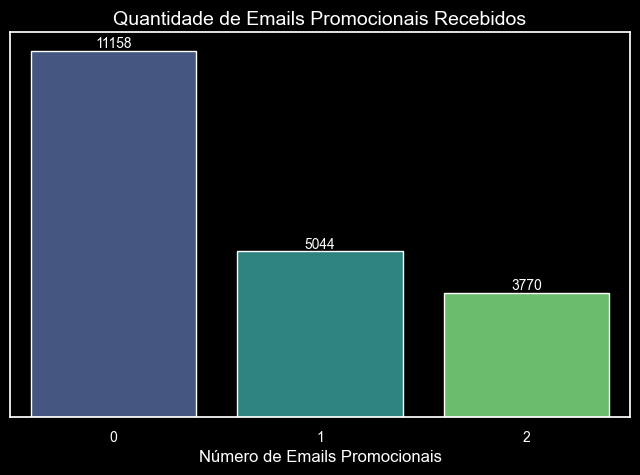

In [70]:
# Contar o número de pessoas para cada valor de emailpromotion
email_counts = person_person['emailpromotion'].value_counts()

# Estilo do gráfico
sns.set(style='darkgrid', rc={"axes.facecolor": "black", "figure.facecolor": "black"})

# Gráfico de barras com ajustes
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    x=email_counts.index, 
    y=email_counts.values, 
    palette=sns.color_palette("viridis", len(email_counts))
)

# Título e rótulos
plt.title("Quantidade de Emails Promocionais Recebidos", color='white', fontsize=14)
plt.xlabel("Número de Emails Promocionais", color='white', fontsize=12)
plt.ylabel("", fontsize=12)

# Cor dos rótulos do eixo
ax.tick_params(axis='x', colors='white', labelsize=10)
ax.tick_params(axis='y', colors='white', labelsize=10)

# Remover os números do eixo Y
ax.set_yticks([])

# Valores no topo de cada barra
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', color='white', fontsize=10)

# Grade
plt.grid(axis='y', linestyle='--', alpha=0.5, color='gray')

plt.show()


#doc: Com base nos dados: 
#     0 = 11158 pessoas não receberam email promocional
#     1 = 5044 pessoas receberam 1 email promocional e 
#     2 = 3770 pessoas receberam 3 emails promocionais

In [71]:
# Atualizar o dicionário df_processados com o df ajustado
df_processados['person_person'] = person_person

In [72]:
person_person.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19972 entries, 286994 to 284377
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   businessentityid  19972 non-null  Int64              
 1   persontype        19972 non-null  object             
 2   firstname         19972 non-null  object             
 3   lastname          19972 non-null  object             
 4   emailpromotion    19972 non-null  Int64              
 5   rowguid           19972 non-null  object             
 6   modifieddate      19972 non-null  datetime64[us, UTC]
dtypes: Int64(2), datetime64[us, UTC](1), object(4)
memory usage: 1.3+ MB


In [73]:
# Padronizar colunas com valores textuais
person_person['persontype'] = person_person['persontype'].str.strip().str.upper()
person_person['firstname'] = person_person['firstname'].str.strip().str.upper()
person_person['lastname'] = person_person['lastname'].str.strip().str.upper()
person_person['rowguid'] = person_person['rowguid'].str.strip().str.upper()

print(person_person.head())

#doc: padronizar as strings nessa etapa, contribui para a execução das demais etapas do pipeline

        businessentityid persontype firstname    lastname  emailpromotion                               rowguid              modifieddate
286994                 1         EM       KEN     SÁNCHEZ               0  92C4279F-1207-48A3-8448-4636514EB7E2 2009-01-07 00:00:00+00:00
295804                 2         EM     TERRI       DUFFY               1  D8763459-8AA8-47CC-AFF7-C9079AF79033 2008-01-24 00:00:00+00:00
279608                 3         EM   ROBERTO  TAMBURELLO               0  E1A2555E-0828-434B-A33B-6F38136A37DE 2007-11-04 00:00:00+00:00
279609                 4         EM       ROB     WALTERS               0  F2D7CE06-38B3-4357-805B-F4B6B71C01FF 2007-11-28 00:00:00+00:00
284378                 5         EM      GAIL    ERICKSON               0  F3A3F6B4-AE3B-430C-A754-9F2231BA6FEF 2007-12-30 00:00:00+00:00


In [74]:

# Garantir que apenas tabelas únicas sejam exportadas
unique_df_processados = {k: v for k, v in df_processados.items()}

# Exportar tabelas para o BigQuery
for table_name, df_cleaned in unique_df_processados.items():
    # Nome da tabela no BigQuery
    output_table = f"{output_dataset}.{table_name}"

    # Configurar job de exportação
    job_config = bigquery.LoadJobConfig(
        write_disposition="WRITE_TRUNCATE"  
    )
    
    # Exportar DataFrame para o BigQuery
    job = client.load_table_from_dataframe(df_cleaned, output_table, job_config=job_config)
    job.result()

    print(f"Tabela {table_name} exportada com sucesso para {output_table}.")

Tabela person_person exportada com sucesso para desafioadventureworks-446600.raw_data_cleaned.person_person.
